Note: For this code the only datasets needed from DeliciousMIL are: train-data.dat, test-data.dat, train-label.dat, test-label.dat.



# 1

In [ ]:
# !pip install pyclustering
# !pip install scikit-learn-extra

## Import necessary libraries

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [ ]:
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score
import pickle
import numpy as np


## Load data

In [ ]:
with open('train-data.dat', 'r') as f:
    train_lines = f.readlines()
with open('test-data.dat', 'r') as f:
    test_lines = f.readlines()

In [ ]:
train_data, test_data = dict(), dict()
n = 0
for line in train_lines:
    train_data[n] = line.split()[2:]
    n += 1
n = 0
for line in test_lines:
    test_data[n] = line.split()[2:]
    n += 1

## Preprocessing

In [ ]:
import re
import itertools

def split_sentences(document):
    sentences = re.findall(r"<\d+> (.+?) <\d+>", document)
    return sentences

train_docs, test_docs, train_bag_len, test_bag_len, train_labels, test_labels = [], [], [], [], [], []
for train_key, train_value in train_data.items():
    train_text_doc = ' '.join(train_value)
    train_docs.append(split_sentences(train_text_doc))
    train_bag_len.append(len(train_docs[train_key])) 
    train_labels.append(train_data[train_key])
for test_key, test_value in test_data.items():
    test_text_doc = ' '.join(test_value)
    test_docs.append(split_sentences(test_text_doc))
    test_bag_len.append(len(test_docs[test_key]))
    test_labels.append(test_data[test_key])
train_labels = np.array(train_labels)
train_labels = train_labels.astype(int)
test_labels = np.array(test_labels)
test_labels = test_labels.astype(int)

# Create two lists of all sentences for the train/test set
train_sentences = list(itertools.chain.from_iterable(train_docs))
test_sentences = list(itertools.chain.from_iterable(test_docs))

# Keep the most popular labels

In [ ]:
column_sums = np.sum(train_labels, axis=0)
most_pop_column = np.argmax(column_sums)

# Keep only the column with the highest sum
y_train = train_labels[:, most_pop_column]
y_test = test_labels[:, most_pop_column]

## Vectorization

In [ ]:
def vectorization(trains, tests, min_df):
    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer(min_df=min_df)
    x_train = vectorizer.fit_transform(trains)
    x_train_m = x_train.toarray()
    x_test = vectorizer.transform(tests)
    x_test_m = x_test.toarray()

    print(x_train_m.shape)
    print(x_test_m.shape)

    return x_train_m, x_test_m

trains_vect, tests_vect = vectorization(train_sentences, test_sentences, min_df=0.02) #the smaller the df the better, later on we use 0.01

## Elbow Method (we also print the most suitable value for the clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

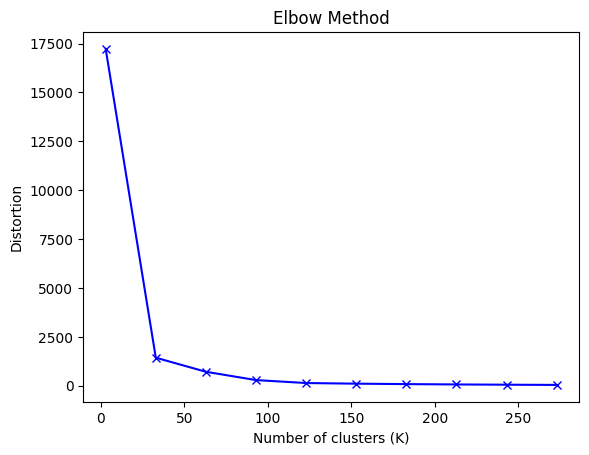

The suitable number of clusters (K) based on the elbow method: 273


In [ ]:
import matplotlib.pyplot as plt
distortions = []
K = range(3, 303, 30)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(trains_vect)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

# Find the suitable number of clusters based on the elbow plot
elbow_index = np.argmin(distortions)
suitable_clusters = K[elbow_index]
print("The suitable number of clusters (K) based on the elbow method:", suitable_clusters)

In [ ]:
# Perform K-means clustering
k = 273 #suitable_clusters  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(trains_vect)

# Get the cluster labels for test set
test_kmeans_labels = kmeans.predict(tests_vect)

# Save the cluster labels
with open('labels.p', 'wb') as file:
    pickle.dump(test_kmeans_labels, file)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Get features for test set based on kmeans labels

X_test = np.zeros((len(test_docs), 273))
with open('labels.p', 'rb') as file:
    test_kmeans_labels = pickle.load(file)
te_kmeans_labels_lists = [] 
c = 0
for length in test_bag_len:
    te_kmeans_labels_lists.append(list(test_kmeans_labels[c:c + length]))
    c += length
for i in range(len(X_test)):
    for j in range(len(te_kmeans_labels_lists[i])):
        X_test[i, te_kmeans_labels_lists[i][j]] += 1  

In [ ]:
train_features = trains_vect 
test_features = tests_vect

print("train_features shape:", train_features.shape)
print("train_labels_filtered shape:", train_labels.shape)
print("y_train shape:", y_train.shape)

label_indices = np.isin(y_train, [0, 1])
train_features_filtered = train_features[label_indices]
train_labels_filtered = train_labels[label_indices]

print("train_features_filtered shape:", train_features_filtered.shape)
print("train_labels_filtered shape:", train_labels_filtered.shape)

# Train Gaussian Naive Bayes classifier
clf = GaussianNB() #try with one first to get some insights
clf.fit(train_features_filtered, train_labels_filtered)
y_pred = clf.predict(test_features)

# Evaluate the classifier
print('Classifier: Gaussian NB')
print('Classification Report:')
print(classification_report(test_labels, y_pred))
print('F1 Score:', f1_score(test_labels, y_pred))

#error: remember to fix

# 2

In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [5]:
with open('train-data.dat', 'r') as train_file:
    train_data = train_file.readlines()

with open('test-data.dat', 'r') as test_file:
    test_data = test_file.readlines()


## Preprocessing

In [6]:
def preprocess_document(document):
    # Remove special characters and convert to lowercase (lowercase also not needed, just in case)
    document = re.sub(r'[^a-zA-Z0-9\s<>]', '', document.lower())

    # Split into sentences and words
    sentences = document.split('\n')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    # Remove words and numbers enclosed in < and > symbols
    preprocessed_sentences = []
    for sentence in sentences:
        words = sentence.split()
        words = [word for word in words if not (word.startswith('<') and word.endswith('>'))]
        preprocessed_sentences.append(' '.join(words))

    # Wrap each line in single quotes
    preprocessed_document = "'" + "'\n'".join(preprocessed_sentences) + "'"

    return preprocessed_document

preprocessed_train_data = [preprocess_document(document) for document in train_data]
preprocessed_test_data = [preprocess_document(document) for document in test_data]

# Print the first 5 lines of preprocessed train-data
print("Preprocessed train-data:")
for i in range(5):
    print(preprocessed_train_data[i])
    print()

# Print the first 5 lines of preprocessed test-data
print("Preprocessed test-data:")
for i in range(5):
    print(preprocessed_test_data[i])
    print()


Preprocessed train-data:
'6705 5997 8310 3606 674 8058 5044 4836 4312 5154 8310 4225'

'1827 1037 8482 483 3567 6172 6172 2892 1362 787 399 777 1332 318 769 4621 3199 1480 6213 971 6890 5909 15 3445 2475 324 4138 3404 6176 65 2926 1375 7705 709 1323 1652 5735 7439 3445 2475 4396 4382 1798 1870 1845 4410 7758 4278 7775 318 769 2898 1923 8193 2930 485 5951 6123 2480 3158 2193 2438 7485 3412 5304 5644 3734 7459 1652 3174 8343 426 1968 7506 561 4051 2722 6717 6172 3432 7859 4595 2351 5951 135 7023 7215 7038 7221 560 4631 4411 1348 8185 5192 3445 2475 5696 5154 361 7953 4245 560 2351 4410 7758 2174 1120 6688 7705 2747 1296 1652 134 5909 7953 4245'

'8482 787 2169 4077 6335 1137 1598 1055 1223 2735 3492 413 838 4457 8392 3631 3699 42 5217 4281 6309 2912 6629 1985 2781 2155 5217 8032 860 7998 1469 4077 682 5950 7654 1561 5217 137 4032 42 5217 29 365 5339 4081 4386 7654 679 5217 620 8197 679 8403 42 5217 2134 5427 980 550 316 762 5582 3148 6039 5217 7378 470 674 8197 1072 42 5217 4164 470 5208

In [7]:
# Load training and test labels
y_train = pd.read_csv('/content/train-label.dat', sep='\t', header=None)[0].values
y_test = pd.read_csv('/content/test-label.dat', sep='\t', header=None)[0].values

# Convert the label strings into binary matrix representation
y_train_bin = np.array([list(map(int, label.split())) for label in y_train])
y_test_bin = np.array([list(map(int, label.split())) for label in y_test])

In [8]:
popular_label = np.argmax(np.sum(y_train_bin, axis=0))

# Keep only the column with the highest sum
y_train_bin = y_train_bin[:, popular_label]
y_test_bin = y_test_bin[:, popular_label]

## Vectorization

In [9]:
vectorizer = CountVectorizer(min_df=0.05)
train_vectors = vectorizer.fit_transform(preprocessed_train_data)
test_vectors = vectorizer.transform(preprocessed_test_data)
print(train_vectors.shape)
print(test_vectors.shape)

(8251, 403)
(3983, 403)


## Train and Evaluate models

In [10]:
# standarize to zero mean and unit variance
scaler = MaxAbsScaler()
scaler.fit(train_vectors)
X_train = scaler.transform(train_vectors)
X_test = scaler.transform(test_vectors)

classifiers = [LogisticRegression(random_state=0),
               RandomForestClassifier(random_state=0)]
names = ['Logistic Regression', 'Random Forest']

for name, clf in zip(names, classifiers):
    print('classifier:', name)
    if name == 'Logistic Regression':
        parameters = {'C':[0.001, 0.01, 0.1, 1.0], 'solver': ['newton-cg', 'lbfgs']}
    else:
        parameters =  {'n_estimators':[100,200,300]}
    grid = GridSearchCV(clf,param_grid=parameters,cv=5,scoring='f1')
    model_grid = grid.fit(X_train, y_train_bin)
    y_pred =  model_grid.predict(X_test)
    print('classification report')
    print(classification_report(y_test_bin, y_pred))
    print('f1  score')
    print(f1_score(y_test_bin, y_pred))


classifier: Logistic Regression
classification report
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      2425
           1       0.62      0.28      0.39      1558

    accuracy                           0.65      3983
   macro avg       0.64      0.59      0.57      3983
weighted avg       0.65      0.65      0.61      3983

f1  score
0.3865248226950354
classifier: Random Forest
classification report
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      2425
           1       0.63      0.31      0.41      1558

    accuracy                           0.66      3983
   macro avg       0.65      0.60      0.59      3983
weighted avg       0.65      0.66      0.62      3983

f1  score
0.413585554600172


## Conclusions

Based on these metrics, we can see that the Random Forest classifier outperforms the Logistic Regression model in terms of both precision and recall for both labels. It achieves a higher F1-score for label 1 (positive class), indicating better performance in capturing the positive instances. Additionally, the Random Forest model has a slightly higher accuracy.

Therefore, considering the overall performance and the F1-score as the evaluation metric, the Random Forest classifier can be considered the better model among the two.